In [18]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import gaussian_kde
from scipy.stats import norm
from scipy.stats import multivariate_normal

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Layer, Dropout, BatchNormalization, LeakyReLU, Lambda
from keras.losses import Loss, mse, MeanSquaredError
from keras.optimizers import Optimizer, Adam
from keras.metrics import Mean
from keras.utils import to_categorical, plot_model, load_img, img_to_array
from keras.callbacks import EarlyStopping
from keras.models import load_model

import tensorflow_probability as tfp
from scipy.stats import gamma

np.random.seed(1234)
tf.random.set_seed(1234)

In [2]:
def printest(args, value):
    return print( "{} : \n {} \n".format(args, value) )

# Exploratory Data Analysis (EDA)

In [3]:
data = pd.read_json('Data/tlc_yellow_trips_2016.json')

In [4]:
data.dropna(inplace = True)

data['pickup_datetime'] = data['pickup_datetime'].str.slice(0, 16)
data['pickup_datetime'] = pd.to_datetime( data['pickup_datetime'], utc = True, format = '%Y-%m-%d %H:%M')

data['dropoff_datetime'] = data['dropoff_datetime'].str.slice(0, 16)
data['dropoff_datetime'] = pd.to_datetime( data['dropoff_datetime'], utc = True, format = '%Y-%m-%d %H:%M')


# Minutes in  a day : 0-1440
data['min_of_day'] = (60*data['pickup_datetime'].dt.hour + data['pickup_datetime'].dt.minute)
# Days in a week: 0-6, where 0 is Monday and 6 Sunday
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
# Days in a year: 1-365 (or 366)
data['day_of_year'] = data['pickup_datetime'].dt.dayofyear
# Time of the  trip
data['trip_duration'] = (data['dropoff_datetime']- data['pickup_datetime']).dt.seconds

# Remove datetime columns
data.drop('pickup_datetime', axis = 1, inplace = True)
data.drop('dropoff_datetime', axis = 1, inplace = True)

## Outliers

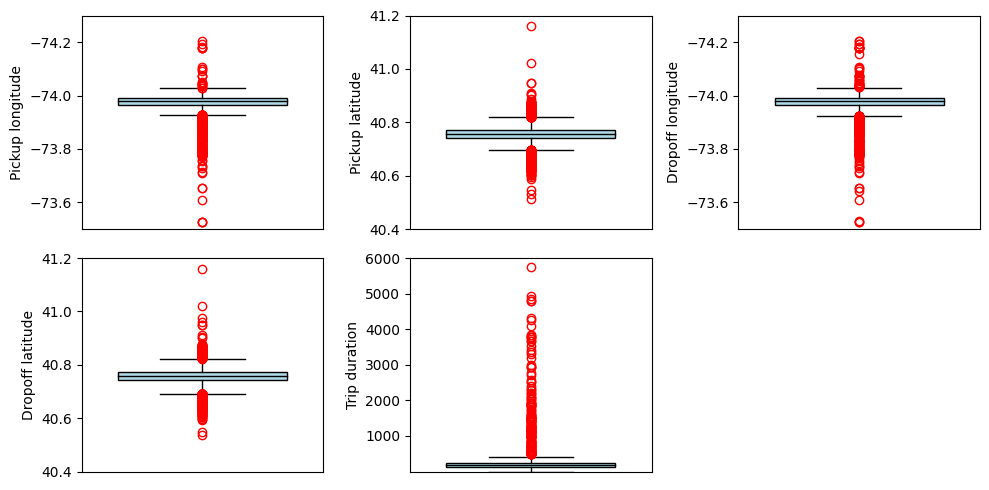

In [5]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10,5))

ylims = [(-73.5, -74.3), (40.4, 41.2), (-73.5, -74.3), (40.4, 41.2), (1, 6000)] 
attributes = list(zip(list(data.columns[:4]) + ['trip_duration'], ylims))

properties = dict(widths=0.7, patch_artist=True,
                  boxprops=dict(facecolor='lightblue', color='black'),
                  capprops=dict(color='black'),
                  whiskerprops=dict(color='black'),
                  flierprops=dict(color='red', markeredgecolor='red'),
                  medianprops=dict(color='black'))

# Loop over the first five axes
for ax, (columns, ylims) in zip(axes.flatten()[:5], attributes):  
    ax.boxplot(data[columns], **properties)
    ax.set_ylabel(columns.replace('_',' ').capitalize())
    ax.set_ylim(ylims)
    ax.set_xticks([])

# turn off the sixth subplot
axes.flatten()[5].axis('off')

plt.tight_layout()
plt.show()


In [6]:
def outlier_bound(data, r = 1.5):
    q1 = np.percentile(data, 25)
    q2 = np.percentile(data, 50)
    q3 = np.percentile(data, 75)
    iqr = q3-q1

    lower_bound = q1 - r * iqr
    upper_bound = q3 + r * iqr
    return lower_bound, upper_bound


r = 2
lb_p_latitude, ub_p_latitude = outlier_bound(data['pickup_latitude'], r = r)
lb_p_longitude, ub_p_longitude = outlier_bound(data['pickup_longitude'], r = r)
lb_d_longitude, ub_d_longitude = outlier_bound(data['dropoff_longitude'], r = r)
lb_d_latitude, ub_d_latitude = outlier_bound(data['dropoff_latitude'], r = r)
_, ub_t_latitude = outlier_bound(data['trip_duration'], r = 1.5)

markdown_table = f"""
| Attribute           | Lower Bound         | Upper Bound         |

pickup Latitude  :      {lb_p_latitude}      {ub_p_latitude}     
Pickup Longitude :     {lb_p_longitude}      {ub_p_longitude}    
Dropoff Longitude:    {lb_d_longitude}       {ub_d_longitude}    
Dropoff Latitude :    {lb_d_latitude}        {ub_d_latitude}
Trip Duration    :           {1}                  {ub_t_latitude}
    
"""

print(markdown_table)


| Attribute           | Lower Bound         | Upper Bound         |

pickup Latitude  :      40.68001651763916      40.834654808044434     
Pickup Longitude :     -74.0418701171875      -73.91312408447266    
Dropoff Longitude:    -74.04498291015625       -73.90864562988281    
Dropoff Latitude :    40.67546367645264        40.83962440490723
Trip Duration    :           1                  420.0
    



# Bayesian Neural Network Layer

## Standard Layer

**variational Bayesian Layer**

This code defines a custom variational Bayesian layer for a neural network. Instead of having fixed weights and biases, each weight and bias is represented as a distribution characterized by mean and standard deviation. These parameters are initialized using Xavier initialization.

During training, the actual values of the weights and biases are stochastically sampled from these distributions. This represents a weight perturbation, where the weights and biases are varied around their mean values according to their standard deviations.

The loss function includes a term for the Kullback-Leibler (KL) divergence, acting as a regularization and guiding the weights and biases towards certain values. In a deterministic forward pass (evaluation mode), the mean values of the distributions could be used directly without sampling.


- During Training (sampling=True): By setting sampling=True, the model samples from the weight and bias distributions. This introduces randomness into the training process, reflecting the uncertainties in the parameters. This stochastic behavior can help the model to explore different regions of the parameter space and can lead to a more robust training process.

- During Prediction (sampling=False): When making predictions, you might want to obtain a single deterministic output. By setting sampling=False, the model uses the mean values of the weight and bias distributions (self.w_loc and self.b_loc), essentially providing the "average" prediction. This gives you a single point estimate that doesn't take into account the uncertainties in the model parameters.


In [7]:
class DenseVariational(Layer):
    def __init__(self, units, activation=None, kl_weight=1e-3, **kwargs):
        """
        Initialize the custom variational dense layer.
        """
        super(DenseVariational, self).__init__(**kwargs)
        self.units = units
        self.activation = activation
        self.kl_weight = kl_weight

    def xavier(self, shape):
        """
        Xavier initialization for the weights and biases.
        """
        return tf.random.truncated_normal(
            shape=shape,
            mean=0.0,
            stddev=np.sqrt(2.0 / sum(shape)))

    def build(self, input_shape):
        """
        Build the layer by defining the variables for means and standard deviations.
        This represents the distributions for the weights and biases.
        """
        d_in = input_shape[-1]
        self.w_mean = tf.Variable(self.xavier((d_in, self.units)), name='w_mean') # Mean for the weight distributions
        self.w_std = tf.Variable(self.xavier((d_in, self.units)) - 5, name='w_std') # Standard deviation for the weight distributions
        self.b_mean = tf.Variable(self.xavier((self.units,)), name='b_mean') # Mean for the bias distributions
        self.b_std = tf.Variable(self.xavier((self.units,)) - 5, name='b_std') # Standard deviation for the bias distributions

    @property
    def weight(self):
        """
        Property representing the weight distributions. This is a collection of normal distributions,
        one for each weight in the layer.
        """
        distribution = tfp.distributions.Normal(self.w_mean, tf.nn.softplus(self.w_std))
        return distribution

    @property
    def bias(self):
        """
        Property representing the bias distributions. This is a collection of normal distributions,
        one for each bias in the layer.
        """
        distribution = tfp.distributions.Normal(self.b_mean, tf.nn.softplus(self.b_std))
        return distribution 


    def call(self, x, Traning = True):
        """
        Perform the forward pass through the layer, either stochastically or deterministically.
        """

        if Traning: # Stochastic foward pass (sampling process)

            w_sample = self.weight.sample()
            b_sample = self.bias.sample() 
            return x @ w_sample + b_sample     
        else: # Deterministic forward pass 
            return x @ self.w_mean + self.b_mean
        
    @property
    def loss(self):
        """
        Compute the loss for the layer, considering the Kullback-Leibler (KL) divergence 
        between the distributions of the weights and biases and a standard normal distribution.
        """

        # Prior distribution
        prior = tfp.distributions.Normal(0, 1)


        kl_w = self.kl_weight*tf.reduce_sum(tfp.distributions.kl_divergence(self.weight, prior))
        kl_b = tf.reduce_sum(tfp.distributions.kl_divergence(self.bias, prior))
        loss = kl_w + kl_b
        return loss

## Layer with Reparametrization trick

In [8]:
class DenseVariational_rt(Layer):
    def __init__(self, units, activation=None, kl_weight=1e-3, name = 'DenseVariational_rt'):
        """
        Initialize the custom variational dense layer parameters.
        """
        super(DenseVariational_rt, self).__init__(name = name)
        self.units = units
        self.activation = tf.keras.activations.get(activation)
        self.kl_weight = kl_weight

    def xavier(self, shape):
        """
        Xavier initialization for weights and biases, ensuring proper scaling at the start of training.
        """
        return tf.random.truncated_normal(
            shape=shape,
            mean=0.0,
            stddev=np.sqrt(2.0 / sum(shape)))

    def build(self, input_shape):
        """
        Build the layer by defining the variables for means and standard deviations.
        Variational Inference: The initialization of mean and standard deviation for weights and biases forms 
        the basis for approximating their posterior distributions using Gaussian distributions. 
        Mean Field: By treating weights and biases as independent random variables with their separate mean and 
        standard deviation, this approach assumes a mean-field approximation to the true joint posterior distribution.
        """
        d_in = input_shape[-1]
        # Initializing mean and standard deviation for weights and biases to represent their posterior distributions.
        self.w_mean = tf.Variable(self.xavier((d_in, self.units)), name='w_mean')
        self.w_std = tf.Variable(self.xavier((d_in, self.units)) - 6, name='w_std')
        self.b_mean = tf.Variable(self.xavier((self.units,)), name='b_mean')
        self.b_std = tf.Variable(self.xavier((self.units,)) - 6, name='b_std')

    def call(self, x, training = True):
        """
        Perform the forward pass through the layer, either stochastically, if in training mode, or deterministically.
        Variational Inference: Stochastic forward pass involves sampling from approximate posterior distributions.
        """
        if training: # Stochastic forward pass (sampling process)
            
            # Softplus to ensure std is positive
            w_std = tf.nn.softplus(self.w_std)
            b_std = tf.nn.softplus(self.b_std)
            
            # Random noise for sampling from Gaussian distributions
            # Correlation problem: Unique perturbations for each data point
            w_noise = tf.random.normal(shape=self.w_mean.shape)
            b_noise = tf.random.normal(shape=self.b_mean.shape)
            
            # Samples from the posterior distributions for weights and biases
            w_sample = self.w_mean + w_std*w_noise
            b_sample = self.b_mean + b_std*b_noise
            output = x @ w_sample + b_sample

        else: # Deterministic forward pass
            output =  x @ self.w_mean + self.b_mean
        
        if self.activation is not None:
            output = self.activation(output)
            
        return output

    def kl_divergence(self, mean_1, std_1, mean_2, std_2):
        """
        Calculate the Kullback-Leibler (KL) divergence between two Gaussian distributions.
        KL Divergence: The method implements the mathematical expression for KL divergence.
        """
        term1 = tf.math.log(std_2 / std_1)
        term2 = (std_1**2 + (mean_1 - mean_2)**2) / (2 * std_2**2)
        kl = term1 + term2 - 0.5
        return tf.reduce_sum(kl)

    @property
    def loss(self):
        """
        Compute the loss for the layer, considering the Kullback-Leibler (KL) divergence 
        between the distributions of the weights and biases and a standard normal distribution.
        KL Divergence: KL divergence is used to calculate the loss.
        ELBO: The loss represents part of the Evidence Lower Bound.
        """

        # Prior distribution
        prior_mean = 0.0 
        prior_std = 1.0

        w_std = tf.nn.softplus(self.w_std)
        b_std = tf.nn.softplus(self.b_std)
        kl_w = self.kl_divergence(self.w_mean, w_std, prior_mean, prior_std)
        kl_b = self.kl_divergence(self.b_mean, b_std, prior_mean, prior_std)
        # kl of the bnn with a weight
        kl_loss = self.kl_weight*(kl_w + kl_b)
        return kl_loss

**Flipout Dense Layer**

Flipout helps to reduce the variance of the gradient estimates. In stochastic optimization, the variance of the gradient estimates can slow down convergence and make the training process unstable. By constructing an estimator that has lower variance, Flipout enables more stable and potentially faster convergence.

In traditional Bayesian Neural Networks, sampling different weight realizations from the weight posterior can be computationally expensive, especially when considering mini-batch training. Flipout addresses this challenge by providing an efficient way to decorrelate the gradients within a mini-batch, allowing more informative gradient estimates.

The idea behind Flipout is to use random signs to perturb the weights, and this perturbation is consistent within an example but varies across examples in a mini-batch. The key is that Flipout maintains the expectation of the weights but introduces variation in the mini-batch, thus enabling stochastic training with weight perturbations.

The method achieves this without significantly increasing the computational overhead, making it an appealing way to incorporate stochastic weights into the network. It can be considered as a smart way to approximate the effect of drawing multiple weight samples per mini-batch without actually having to do so, making it more efficient than traditional stochastic weight methods.

# Bayesian Neural Network Model

In [9]:
class BNN(Model):
    def __init__(self,
                 layer_units: list = [5, 5],
                 output_unit: int = 1,
                 activation_func: str = 'relu',
                 kl_weight: float = 1e-3,
                 name = "BNN"):

        super(BNN, self).__init__(name=name)

        self.layer_units = layer_units
        self.output_unit = output_unit
        self.activation_func = activation_func
        self.kl_weight = kl_weight

        self.steps = []
        for i in range(len(layer_units)):
            self.steps += [DenseVariational_rt(units=layer_units[i],
                                               kl_weight=self.kl_weight, 
                                               activation=activation_func,
                                               name='DenseVariational_{}'.format(i))]
            
        self.steps += [DenseVariational_rt(units=self.output_unit,
                                            kl_weight=self.kl_weight,
                                            activation=None,
                                            name='OutputLayer')]
    
    def call(self, x):
        for layer in self.steps:
            x = layer(x)
        return x
    
    @property
    def losses(self):
        """Sum of the KL divergences between priors + posteriors"""
        return tf.reduce_sum([layer.loss for layer in self.steps]) 

# Regression BNN Model

The transformation function `lambda x: tf.sqrt(tf.math.reciprocal(x)) `is applied to map the Gamma distribution to the standard deviation. This transformation ensures that the predicted standard deviation is positive, and the reciprocal square root is a common transformation for this purpose.

By defining the standard deviation using a Gamma distribution, you're allowing the model to learn and represent the uncertainty in the data. This uncertainty is crucial when calculating the likelihood of observed data given the model, as it essentially quantifies how "surprised" the model is by the observed data.

The likelihood function is central to Bayesian learning. It's used to update the beliefs about the parameters given the observed data. In this case, the parameters include the shape and rate of the Gamma distribution, which models the standard deviation of the weights.

The Gamma distribution is flexible and can model a wide range of shapes for the standard deviation. By learning the parameters of the Gamma distribution, the model can adapt to the specific characteristics of the data.

Absolutely, here is your refined text:

In this scenario, the log-likelihood is derived from the likelihood function's logarithm, used to assess the probability of observing the given data based on the parameters or their distributions in our model.

$$
\log P(Y = y; \mu, \sigma) = -\frac{1}{2}\log(2\pi) - \log(\sigma) - \frac{1}{2\sigma^2}(y - \mu)^2
$$

Here, $Y$ is the random variable representing your distribution, $y$ is a realization of $Y$ (a point in your data), and $\mu$ and $\sigma$ are the parameters of the distribution.

The training process seeks to pinpoint the parameters that enhance the log-likelihood across the entire dataset through Maximum Likelihood Estimation (MLE), effectively minimizing the negative log-likelihood.

Practically, this is accomplished by defining a probability distribution and invoking its `log_prob` method with the observed data as inputs.

In [10]:
class BNNRegression(Model):
    def __init__(self, layers, name = 'Regression'):
        super(BNNRegression, self).__init__(name = name)

        # BNN to predict the mean
        self.mean_bnn = BNN(layer_units = layers)

        # Variational distribution for observed data
        self.std_alpha = tf.Variable([10.0], name='std_alpha')
        self.std_beta = tf.Variable([10.0], name='std_beta')

        self.total_kl_tracker = Mean(name = 'total kl')
        self.std_kl_loss_tracker = Mean(name = 'std kl')
        self.net_kl_loss_tracker = Mean(name = 'net kl')
        self.elbo_tracker = Mean(name = 'elbo')

        self.transform = lambda x: tf.sqrt(tf.math.reciprocal(x))

    @property
    def metrics(self):
        tracker = [self.total_kl_tracker, self.std_kl_loss_tracker, 
                   self.net_kl_loss_tracker, self.elbo_tracker]
        return tracker

    def call(self, x, training = True):

        # Predict means
        mean_preds = self.mean_bnn(x, training = training)
        
        # Standard deviations are computed from a Gamma
        posteior = tfp.distributions.Gamma(self.std_alpha, self.std_beta)
        
        N = tf.shape(x)[0]
        if training:
            std_preds = self.transform(posteior.sample([N]))
        else:
            std_preds = tf.ones([N, 1])*self.transform(posteior.mean([N]))

        return tf.concat([mean_preds, std_preds], 1)
    
    def train_step(self, data):
        return self._process_step(data)
    
    @tf.function
    def tf_evaluate(self, x,  y):
        N = tf.shape(x)[0]
        with tf.GradientTape() as tape:

            log_likelihoods  = self.log_likelihood(x, y)
            kl_losses = self.losses

            elbo_loss = kl_losses[0]/float(N)  - tf.reduce_mean(log_likelihoods)

        grads = tape.gradient(elbo_loss, self.trainable_weights)  
        return kl_losses, elbo_loss, grads

    def _process_step(self, data):
        x, y = data
        kl_losses, elbo_loss, grads = self.tf_evaluate(x, y)
        
        if self.optimizer != None:
            self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        total_kl_loss, bnn_kl_loss, std_kl_loss = kl_losses

        self.total_kl_tracker(total_kl_loss)
        self.std_kl_loss_tracker(std_kl_loss)
        self.net_kl_loss_tracker(bnn_kl_loss)
        self.elbo_tracker(elbo_loss) 

        dict_losses = {"total kl":self.total_kl_tracker.result(),
                        "std kl":self.std_kl_loss_tracker.result(),
                        "net kl":self.net_kl_loss_tracker.result(),
                        "ELBO":self.elbo_tracker.result() }
        
        return dict_losses
                            
    def log_likelihood(self, x, y, training = True):
        
        # Log of gaussian distribution
        log_prob = lambda mean, std, y_true: -0.5 * tf.math.log(2 * np.pi) - tf.math.log(std) - 0.5 * tf.square((y_true - mean) / std)

        preds = self.call(x, training = training)
        mean,std = preds[:, 0], preds[:, 1]
        
        return log_prob(mean, std, y)
    
    @tf.function
    def sample(self, x):
        preds = self.call(x)
        return tfp.distributions.Normal(preds[:,0], preds[:,1]).sample()
    
    def samples(self, x, n_sample = 1):
        N = x.shape[0]
        samples = np.zeros((N, n_sample))
        for i in range(n_sample):
           samples[:,i] = self.sample(x)
        return samples
    
    @property
    def losses(self):
        # KL loss from the network
        bnn_kl_loss = self.mean_bnn.losses

        # KL loss from the standard deviation based on data
        posterior = tfp.distributions.Gamma(self.std_alpha, self.std_beta)
        prior  = tfp.distributions.Gamma(10.0, 10.0)  #prior is fixed 
        std_kl_loss = tfp.distributions.kl_divergence(posterior, prior)

        #Total loss
        total_kl_loss = bnn_kl_loss + std_kl_loss

        return [total_kl_loss, bnn_kl_loss, std_kl_loss]

# Main

In [11]:
data = pd.read_json('Data/tlc_yellow_trips_2016.json')

data.dropna(inplace = True)

data['pickup_datetime'] = data['pickup_datetime'].str.slice(0, 16)
data['pickup_datetime'] = pd.to_datetime( data['pickup_datetime'], utc = True, format = '%Y-%m-%d %H:%M')

data['dropoff_datetime'] = data['dropoff_datetime'].str.slice(0, 16)
data['dropoff_datetime'] = pd.to_datetime( data['dropoff_datetime'], utc = True, format = '%Y-%m-%d %H:%M')


# Minutes in  a day : 0-1440
data['min_of_day'] = (60*data['pickup_datetime'].dt.hour + data['pickup_datetime'].dt.minute)
# Days in a week: 0-6, where 0 is Monday and 6 Sunday
data['day_of_week'] = data['pickup_datetime'].dt.dayofweek
# Days in a year: 1-365 (or 366)
data['day_of_year'] = data['pickup_datetime'].dt.dayofyear
# Time of the  trip
data['trip_duration'] = (data['dropoff_datetime']- data['pickup_datetime']).dt.seconds

# Remove datetime columns
data.drop('pickup_datetime', axis = 1, inplace = True)
data.drop('dropoff_datetime', axis = 1, inplace = True)

In [12]:
def clip(df, lower_bound, upper_bound, col):
    for c in col:
        df = df[(df[c]>lower_bound) & (df[c]<upper_bound)]
    return df


data = clip(data, 1, 4*ub_t_latitude, ['trip_duration'])
data = clip(data,  lb_p_longitude, ub_p_longitude,
             ['pickup_longitude', 'dropoff_longitude'])
data = clip(data, lb_d_latitude, ub_d_latitude,
             ['pickup_latitude', 'dropoff_latitude'])

data['trip_duration'] = np.log(data['trip_duration'])

# Normalize data
data = (data - data.mean()) / data.std()

data = data.astype('float32')

# Shuffle
data = data.sample(frac=1)

# Separate in- from dependent variables
x_taxi = data.drop('trip_duration', axis=1)
y_taxi = data['trip_duration']

In [13]:
n = len(data)
n_val = int(0.2*n)   # 20% for validation
n_test = int(0.2*n)  # 20% for test
n_train = int(0.6*n) # 60% for train

idx = np.arange(n)
np.random.shuffle(idx)
df_shuffled = data.iloc[idx]

df_train = df_shuffled.iloc[:n_train].copy()
df_val = df_shuffled.iloc[n_train:n_train+n_val].copy()
df_test = df_shuffled.iloc[n_train+n_val:].copy()

x_train = df_train.drop('trip_duration', axis=1).to_numpy('float32', True)
y_train = df_train['trip_duration'].to_numpy('float32', True)

In [14]:
model = BNNRegression([ 10])
model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate=0.001))
history = model.fit(x_train, y_train, epochs = 10, batch_size= 32 )

Epoch 1/10
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


2023-09-14 08:33:02.334622: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [2]
	 [[{{node shape}}]]
2023-09-14 08:33:02.334700: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [2]
	 [[{{node shape}}]]
2023-09-14 08:33:02.340140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [2]
	 [[{{node shape}}]]
2023-09-14 08:33:02.340195: I tens

1135/1135 [==============================] - 2s 719us/step - total kl: 0.4099 - std kl: 7.9042e-04 - net kl: 0.4091 - ELBO: 1.6036
Epoch 2/10
1135/1135 [==============================] - 1s 679us/step - total kl: 0.3993 - std kl: 7.2371e-04 - net kl: 0.3986 - ELBO: 1.4512
Epoch 3/10
1135/1135 [==============================] - 1s 670us/step - total kl: 0.3918 - std kl: 0.0032 - net kl: 0.3886 - ELBO: 1.4439
Epoch 4/10
1135/1135 [==============================] - 1s 672us/step - total kl: 0.3933 - std kl: 0.0098 - net kl: 0.3834 - ELBO: 1.4259
Epoch 5/10
1135/1135 [==============================] - 1s 678us/step - total kl: 0.3974 - std kl: 0.0172 - net kl: 0.3802 - ELBO: 1.4087
Epoch 6/10
1135/1135 [==============================] - 1s 675us/step - total kl: 0.4029 - std kl: 0.0259 - net kl: 0.3771 - ELBO: 1.4014
Epoch 7/10
1135/1135 [==============================] - 1s 702us/step - total kl: 0.4052 - std kl: 0.0306 - net kl: 0.3746 - ELBO: 1.3967
Epoch 8/10
1135/1135 [===============

# Distribution Testes

**Gamma**

When you utilize this Gamma distribution as a prior for the standard deviation of the observed data in a Bayesian context, the parameters std_alpha and std_beta (the shape and rate parameters of the Gamma distribution, respectively) become learnable parameters in the model. During the training process, the model may update these parameters based on the data, resulting in a posterior distribution that best represents the uncertainty in the standard deviation.

 The inverse Gamma distribution is commonly used as a prior for the precision (reciprocal of the variance) in Bayesian statistics. Taking the square root of the reciprocal of a sample from a Gamma distribution is equivalent to sampling from a square-root inverse Gamma distribution.

2023-09-14 08:33:11.318628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [2]
	 [[{{node shape}}]]
2023-09-14 08:33:11.318769: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [2]
	 [[{{node shape}}]]
2023-09-14 08:33:11.324135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'shape' with dtype int32 and shape [2]
	 [[{{node shape}}]]
2023-09-14 08:33:11.324208: I tens

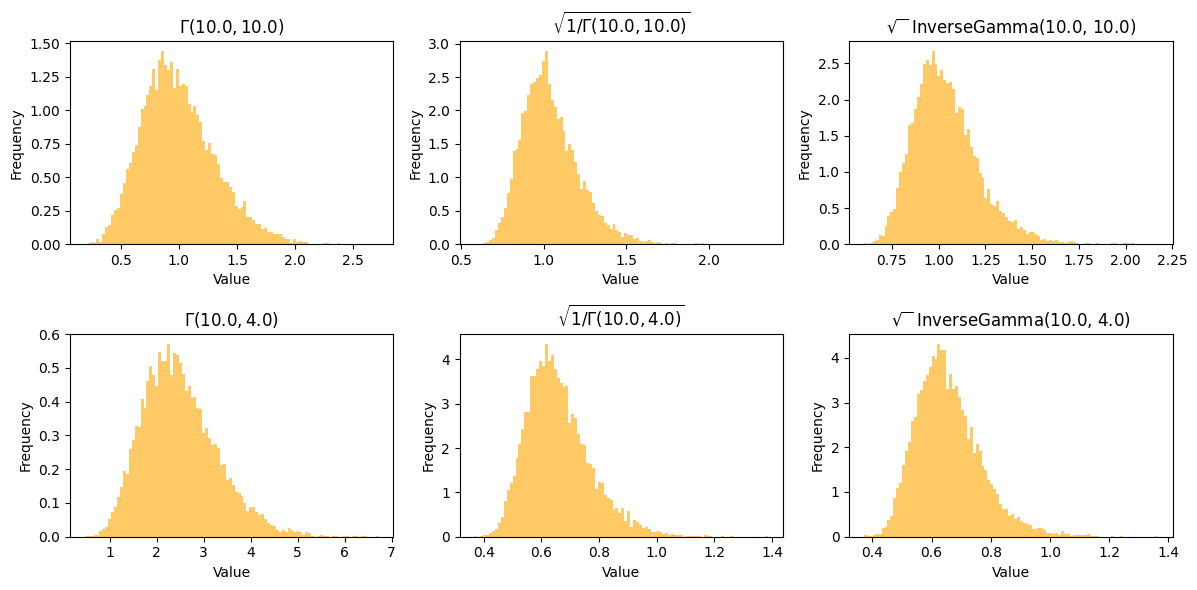

In [15]:
def plot_histograms(plot_data, titles , bins = 100, nrows = 2, ncols = 2, figsize = (12, 6)):
    fig, axes = plt.subplots(nrows = nrows, ncols = ncols, figsize = figsize)
    # Loop over the axes to plot each histogram
    for ax, data, title in zip(axes.flatten(), plot_data, titles):
        ax.hist(data, bins = bins, density = True, alpha = 0.6, color = 'orange')
        ax.set_title(title)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

batch_size = 10000
input_features = 2
x_input = np.random.randn(batch_size, input_features).astype(np.float32)

# alpha and beta would be the learnable parameters
std_alpha = [10.0, 10.0]   # shape parameter (concentration): alpha = k
std_beta = [10.0, 4.0 ]   # rate parameter: beta = 1/theta --> theta = 1/10
posterior = tfp.distributions.Gamma(std_alpha, std_beta)
inv_posterior = tfp.distributions.InverseGamma(std_alpha, std_beta)

N = x_input.shape[0]
transform = lambda x: np.sqrt(np.reciprocal(x))
sqrt = lambda x: np.sqrt(x)

std_samples  = posterior.sample([N]).numpy()
std_samples_tranform = transform(posterior.sample([N]))

inv_std_samples  = inv_posterior.sample([N]).numpy()
inv_std_samples_tranform = sqrt(inv_posterior.sample([N]))

nrow, ncols = [2, 3]
            
plot_data = [std_samples[:,0:1] , std_samples_tranform[:,0:1], inv_std_samples_tranform[:,0:1],
             std_samples[:,1:2] , std_samples_tranform[:,1:2], inv_std_samples_tranform[:,1:2]]

titles = [
    '$\Gamma({}, {})$'.format(std_alpha[0], std_beta[0]), 
    '$ \sqrt{{1/ \Gamma({}, {})}}$'.format(std_alpha[0], std_beta[0]), 
    '$\sqrt{{ ~}}$ InverseGamma({}, {})'.format(std_alpha[0], std_beta[0]),
    '$\Gamma({}, {})$'.format(std_alpha[1], std_beta[1]), 
    '$\sqrt{{1/ \Gamma({}, {})}}$'.format(std_alpha[1], std_beta[1]),
    '$\sqrt{{ ~}}$ InverseGamma({}, {})'.format(std_alpha[1], std_beta[1])
]


plot_histograms(plot_data , titles, nrows = nrow, ncols = ncols)

**Initializer**

In the Bayesian neural network layer defined in the class BayesianDenseLayer, the standard deviation parameters for both weights and biases are initialized with a value subtracted by 6. The reason for this specific choice is multi-faceted:

The subtraction of 6, followed by the softplus activation, results in small initial standard deviations, creating an almost deterministic behavior in the beginning stages of training. This is beneficial because it helps stabilize the training process early on by preventing the weights from exhibiting excessive variation, which can lead to erratic learning.

Starting with small standard deviations allows the network to begin learning with a strong deterministic assumption and gradually adapt to the appropriate level of uncertainty as training progresses. This approach fosters controlled learning, enabling the network to learn the correct uncertainties over time without being overly influenced by them at the start.

This method of initialization also avoids the problem of large standard deviations leading to sampling extreme weight values, maintaining stability throughout the training.

Overall, this technique reflects a thoughtful approach to initializing a Bayesian neural network, ensuring a balanced and stable learning process by delicately controlling the uncertainty in its parameters from the outset.

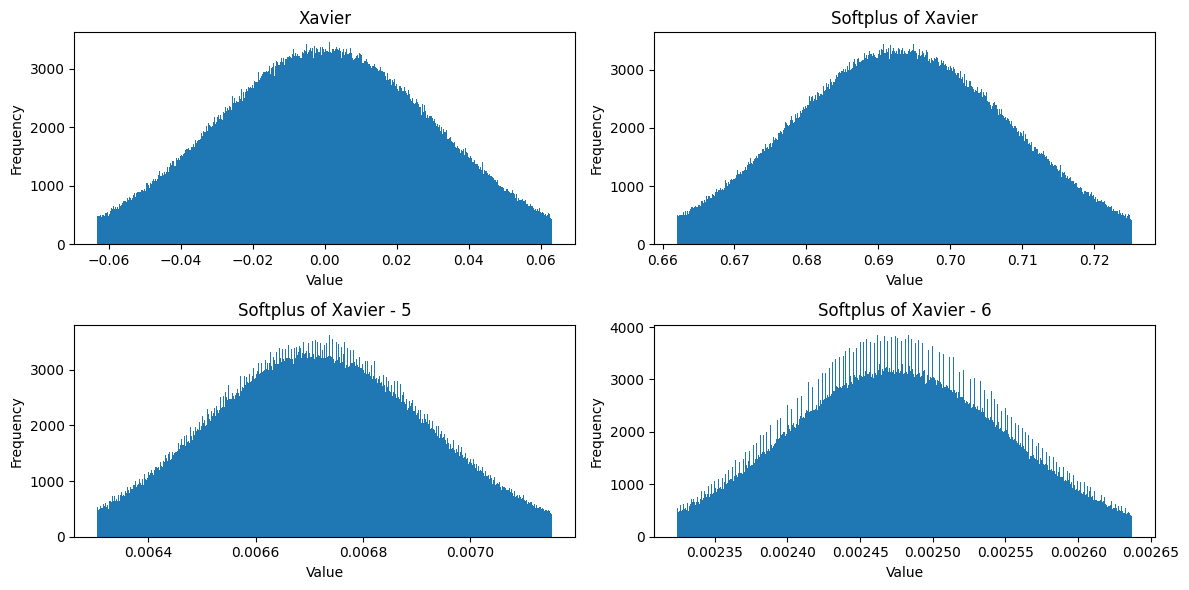

In [16]:
# Test for the Xavier initializer with truncated normal distribution
def xavier(n_in, n_out):
    return tf.random.truncated_normal(
        shape=(n_in, n_out), 
        mean=0.0,
        stddev=np.sqrt(2.0 / (n_in + n_out)))

def plot_histograms(plot_data, titles, bins = 500, nrows = 2, ncols = 2, figsize = (12, 6)):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

    # Loop over the axes to plot each histogram
    for ax, data, title in zip(axes.flatten(), plot_data, titles):
        ax.hist(data, bins= bins, density=False)
        ax.set_title(title)
        ax.set_xlabel('Value')
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

softplus = lambda x: np.log(1 + np.exp(x))

n_in, n_out = [1000, 1000]  
xavier_values = xavier(n_in, n_out)
xavier_values = xavier_values.numpy()

plot_data = [
    xavier_values.flatten()[:,None],
    softplus(xavier_values.flatten()[:,None]),
    softplus(xavier_values.flatten()[:,None]-5),
    softplus(xavier_values.flatten()[:,None]-6)
]

titles = ['Xavier', 'Softplus of Xavier', 'Softplus of Xavier - 5','Softplus of Xavier - 6']


plot_histograms(plot_data, titles)


In this Bayesian neural network implementation, the weights and biases are modeled as random variables following a normal distribution. The `self.weight.sample()` and `self.bias.sample()` methods perform the sampling, allowing the network to consider uncertainty in these parameters.

So When call the `sample()` method on a `tfp.distributions.Normal` object, it performs the sampling using the equation 

$$w_i = \mu_i + \sigma_i \epsilon_i,$$

where $\mu_i$ is the mean, $\sigma_i$ is the standard deviation of the distribution, and $\epsilon_i$ is a random noise term usually sampled from a standard normal distribution, i.e., $\epsilon_i \sim \mathcal{N}(0, 1)$


The following code defines a normal distribution for each weight, with the mean and standard deviation determined by the Xavier initialization.
During each forward step in the training or inference process, actual weight values would be sampled from these distributions.
The plotted PDFs visualize these distributions, showing where the weight values are likely to be sampled from.

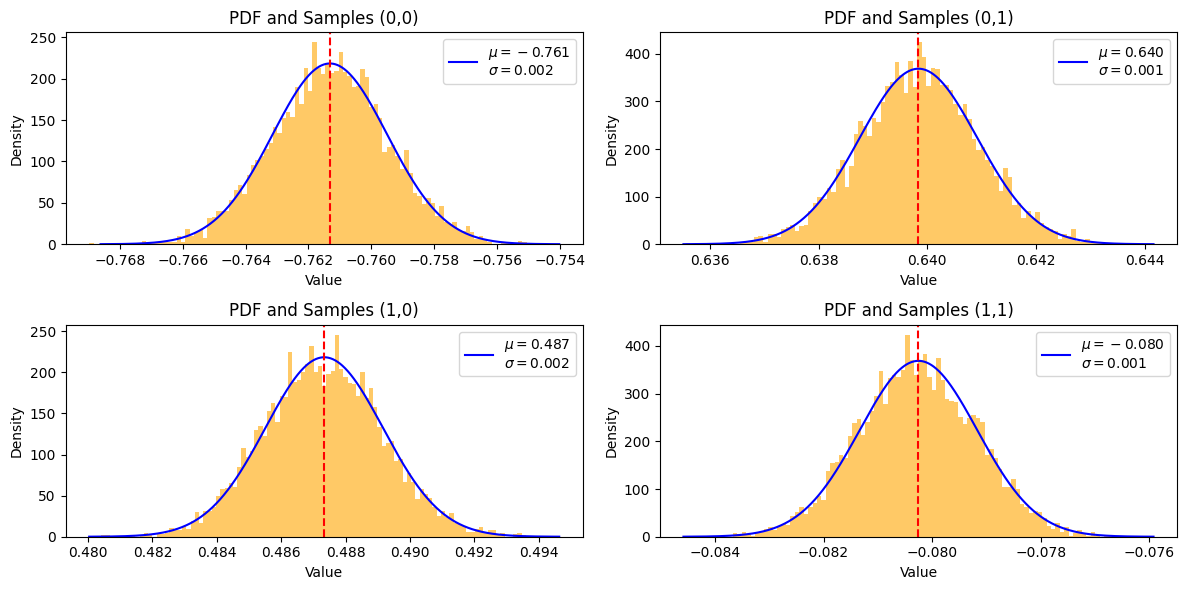

In [17]:
n_in, n_out = [2, 2] 
w_mean = xavier(n_in, n_out)
w_std = xavier(2, n_out) - 6


normal_distribution = tfp.distributions.Normal(loc=w_mean, scale=tf.nn.softplus(w_std))


fig, axes = plt.subplots(nrows=n_in, ncols=n_out, figsize=(12, 6))

# Number of samples for each histogram
num_samples = 5000

# Iterate over rows and columns
for i in range(n_in):
    for j in range(n_out):
        # Get mean and standard deviation for specific indices
        mu = w_mean[i, j]
        sigma = tf.nn.softplus(w_std[0, j])

        # Create x values for PDF plotting
        x = np.linspace(float(mu - 4*sigma), float(mu + 4*sigma), 1000)

        # Create a distribution for this specific mean and standard deviation
        single_normal_distribution = tfp.distributions.Normal(loc=mu, scale=sigma)

        # Evaluate PDF
        pdf = single_normal_distribution.prob(x)

        # Draw samples from the distribution
        samples = single_normal_distribution.sample(num_samples)

        # Plot the PDF
        ax = axes[i, j]
        ax.plot(x, pdf, label=f'$\mu = {mu:.3f}$\n$\sigma = {sigma:.3f}$', color='blue')

        # Plot the histogram of samples
        ax.hist(samples, bins=100, density=True, alpha=0.6, color='orange')

        # Draw a vertical line at the mean
        ax.axvline(mu, color='r', linestyle='--')

        ax.set_title(f'PDF and Samples ({i},{j})')
        ax.set_xlabel('Value')
        ax.set_ylabel('Density')
        ax.legend()

plt.tight_layout()
plt.show()
